In [238]:
import os
import re
import pandas as pd
import multiprocessing as mp

In [239]:
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

# Define all functions

In [253]:
#--------------------------------------------------------------------------------
#----------Filtering unfunctional clonotypes and remove too small files----------
#--------------------------------------------------------------------------------
def filter_unfunctional_clones_and_small_samples(path_to_input_file, path_to_output_file, N=2000):
    #-----check that file eist----
    if not os.path.exists(path_to_input_file):
        return (path_to_input_file, "cannot find file")
    #-----read input file----
    tcr_input=pd.read_csv(path_to_input_file, sep="\t")
    #-----check header-------
    if tcr_input.columns[0]!="count":
        return (path_to_input_file, "bad file?") 
    #-----check number of functional clonotypes
    tcr_input=tcr_input.loc[~tcr_input["cdr3aa"].str.contains("\*|_")]
    if tcr_input.shape[0]<N:
        return (path_to_input_file, "not enougth clonotypes")   
    tcr_input=tcr_input.sort_values(by="count", ascending=False) #sort by counts
    #-----adjust frquencies in subset table (make them sum to 1)
    tcr_input.loc[:,"freq"]=tcr_input["count"]/tcr_input["count"].sum()
    #-----save subsampled table to file
    tcr_input.to_csv(path_to_output_file,index=False,sep="\t")
    return (path_to_input_file,"good")

def filter_unfunctional_clones_and_small_samples_batch(list_with_sample_names, folder_with_files, output_folder, cores=10):
    #create output folder if it does not exist
    if not os.path.exists(output_folder): 
        os.mkdir(output_folder)
        
    input_files_paths=[str(folder_with_files)+"/"+str(sample_name) for sample_name in list_with_sample_names]
    output_files_paths=[str(output_folder)+"/"+str(sample_name) for sample_name in list_with_sample_names]
    
    pool = mp.Pool(cores) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
    results=pool.starmap(filter_unfunctional_clones_and_small_samples, zip(input_files_paths,output_files_paths))
    pool.close()
    good_or_bad=dict(results)
    return good_or_bad


In [241]:
#--------------------------------------------------------------------------------
#----------Estimate V-usage----------
#--------------------------------------------------------------------------------
def sample_V_usage(path_to_file):
    clonoset=pd.read_csv(path_to_file, sep="\t")
    #sometimes more than one V-segment is assigned to clonotype (HIP_full for example)
    #so let's take only the first one V-segment
    clonoset["v"]=clonoset["v"].apply(lambda x: x.split(",")[0])
    #group by segment annd find sum
    sample_v_usage=clonoset.groupby(["v"]).sum()
    return (path_to_file, dict(sample_v_usage["freq"]))

def V_usage_estimation_batch(list_with_sample_names, folder_with_files, cores=10):
    v_usage={}
    all_v=set()
    paths_to_files=[str(folder_with_files)+"/"+str(file_name) for file_name in list_with_sample_names]
    pool = mp.Pool(cores) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
    results=pool.map(sample_V_usage, paths_to_files)
    pool.close()
    batch_v_usage=dict(results)
    return batch_v_usage


def save_V_usage_to_file(v_usage_dict,output_file_name):
    all_v=set()
    for sample_name in v_usage_dict:
        all_v=all_v|set(v_usage_dict[sample_name])
    all_v=list(all_v)
    with open(output_file_name, "w") as out_file:
        out_file.write("sample_id\t"+"\t".join(all_v))
        for sample_name in v_usage:
            out_file.write("\n"+str(sample_name))
            for v_segment in all_v:
                if v_segment in v_usage_dict[sample_name]:
                    out_file.write("\t"+str(v_usage_dict[sample_name][v_segment]))
                else:
                    out_file.write("\t0")
                    

In [242]:
#--------------------------------------------------------------------------------
#----------Collapse V-subfamilies----------
#--------------------------------------------------------------------------------
def collapse_v_subfamilies(v_usage_df):
    #copy sample_id column
    v_usage_collapse_df=v_usage_df.loc[:,'sample_id']
    #copy columns with TRBV that do not have subfamilies
    v_usage_collapse_df=pd.concat([v_usage_collapse_df,
                                   v_usage_df.loc[:,[xT for xT in v_usage_df.columns if xT.startswith("TRBV") & (re.search("-",xT)==None)]]], axis=1)
    #sum all TRBV from different subfamilies of same family
    for trbv in set([xT.split("-")[0] for xT in v_usage_df.columns if xT.startswith("TRBV") & (re.search("-",xT)!=None)]):
        #print(trbv)
        #print(hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].columns)
        v_usage_collapse_df[trbv]=v_usage_df.loc[:,[xT for xT in v_usage_df.columns if re.search(str(trbv)+"-",xT)!=None]].sum(axis=1)
        
    return v_usage_collapse_df
        
 

In [287]:
#--------------------------------------------------------------------------------
#----------Plot V-usage---------- (optional)
#--------------------------------------------------------------------------------
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import zscore
%matplotlib inline

def plot_V_usage_z_scored(v_usage_df,z_score=True):
    v_usage_to_plot=v_usage_df.drop(columns=["sample_id","Batch"])
    labels=list(v_usage_df["Batch"])
    sample_id=list(v_usage_df["sample_id"])
    v_usage_to_plot.index=sample_id


    lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
    row_colors = pd.DataFrame(labels)
    row_colors[0]=list(map(lambda x: (lut[x]), row_colors[0]))
    row_colors.index=sample_id


    legend_TN = [mpatches.Patch(color=lut[l], label=l) for l in set(labels)]
    
    #--strange way to find vmin and vmax for plot
    temp_df=pd.DataFrame.from_records(list(v_usage_to_plot.apply(zscore,axis=1)),
                                      index=sample_id,
                                      columns=v_usage_to_plot.columns)
    extr_value=max([df.max().max(),-df.min().min()])
    vmax_z=abs(extr_value)
    vmin_z=-vmax_z
    #----
    if z_score:
        g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),row_colors=row_colors,cmap="vlag", vmin=vmin_z, vmax=vmax_z,
              yticklabels=False, z_score=0)

        g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
        
        
        
        #g=sns.clustermap(temp_df,figsize=(20, 15),cmap="vlag",row_colors=row_colors, vmin=vmin, vmax=vmax,
        #  yticklabels=False, z_score='none')

        #g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)   
    else:
        g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),cmap="OrRd",row_colors=row_colors,
          yticklabels=False)

        g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
    
    return g



In [316]:
#--------------------------------------------------------------------------------
#----------Estimate size-factor for batch V-usage adjustment----------
#--------------------------------------------------------------------------------
#REMOVE TRBV if it at least in one dateset is 0!!

def find_batch_scaling_factor(v_usage_with_batch_column):
    #--Find median V-usage for each TRBV in each batch
    trbv_frequency={}
    for batch in set(v_usage_with_batch_column["Batch"]):
        trbv_frequency[batch]={}
        for trbv in set([xT.split("-")[0] for xT in v_usage_with_batch_column.columns if xT.startswith("TRBV")]):
             trbv_frequency[batch][trbv]=v_usage_with_batch_column.loc[v_usage_with_batch_column["Batch"]==batch, trbv].median()
    #--Print table with median V-usage
    trbv_frequency_df=pd.DataFrame(trbv_frequency) 
    print("Median V-usage")
    print(trbv_frequency_df.loc[trbv_frequency_df.sum(axis=1).sort_values(ascending=False).index])
    #--Find scaling factor
    size_factor=dict([(dataset_name,{}) for dataset_name in trbv_frequency_df.columns])
    for index, row in trbv_frequency_df.iterrows():
        if sum(row==0)>0: #REMOVE TRBV if it at least in one dateset is 0
            for dataset_name in trbv_frequency_df.columns:
                size_factor[dataset_name][row.name]=0
        else:
            #median_freq=row[["AB","HIP","FMBA","KECK"]].median()
            median_freq=row.median()
            for dataset_name in trbv_frequency_df.columns:
                size_factor[dataset_name][row.name]=median_freq/row[dataset_name]
    return size_factor


In [ ]:
#--------------------------------------------------------------------------------
#----------Adjust V-usage----------
#--------------------------------------------------------------------------------

# Apply pipeline

In [295]:
#create output folder
global_output_folder="/home/taumata/COV_V_usage_adjustment_v2"
if not os.path.exists(global_output_folder): 
        os.mkdir(global_output_folder)

### Adaptive

In [296]:
#-define batch name
batch="Adaptive"

In [297]:
#read metadata in df
metadata=pd.read_csv("../adaptive/adaptive-metadata-edited.tsv",sep="\t")
#check column names and some rows
metadata.head()


Unnamed: 0  ImmuneCODERelease            Dataset        sample_name  \
0           0                2.0  COVID-19-Adaptive  ADIRP0000106_TCRB   
1           1                2.0  COVID-19-Adaptive  ADIRP0000362_TCRB   
2           2                2.0  COVID-19-Adaptive  ADIRP0000423_TCRB   
3           3                2.0  COVID-19-Adaptive  ADIRP0002104_TCRB   
4           4                2.0  COVID-19-Adaptive  ADIRP0000057_TCRB   

     subject_id     Virus Diseases       Age Biological Sex  \
0  ADIRP0000106  COVID-19 Positive  41 Years         Female   
1  ADIRP0000362  COVID-19 Positive  51 Years         Female   
2  ADIRP0000423  COVID-19 Positive  32 Years         Female   
3  ADIRP0002104  COVID-19 Positive  49 Years           Male   
4  ADIRP0000057  COVID-19 Positive  49 Years         Female   

                Racial Group Tissue Source  ... uses_arb  \
0                   Hispanic         Blood  ...      NaN   
1                  Caucasian         Blood  ...      NaN   
2  Asian or Pacific Islander         Blood  ...      NaN   
3  Black or African American         Blood  ...      NaN   
4         Mixed racial group         Blood  ...      NaN   

  uses_asthma_quick_relief uses_autoimmune_medications  \
0                      NaN                         NaN   
1                      NaN                       False   
2                      NaN                         NaN   
3                      NaN                         NaN   
4                      NaN                         NaN   

  uses_corticosteroids_for_asthma uses_immunosuppressant uses_nsaid visit  \
0                             NaN                  False        NaN   1.0   
1                             NaN                  False        NaN   1.0   
2                             NaN                  False        NaN   1.0   
3                             NaN                  False        NaN   1.0   
4                             NaN                  False        NaN   1.0   

   weight_kg  who_ordinal_scale  COVID-19-status  
0        NaN                NaN        recovered  
1        NaN                NaN        recovered  
2        NaN                NaN        recovered  
3        NaN                NaN        recovered  
4        NaN                NaN            acute  

[5 rows x 159 columns]

In [298]:
#Add some universal columns to metadata ["file_full_name","Batch","COVID-19-status"]
metadata["file_full_name"]=metadata["sample_name"]+".tsv.txt"
metadata["Batch"]=batch

In [299]:
#count how much donors with each COVID-status in df 
metadata['COVID-19-status'].value_counts()

acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64

In [300]:
#take only acute (?)
metadata=metadata.loc[metadata['COVID-19-status']=="acute"]


In [302]:
#-----------------------------------
#--Filter nonfunctional clonotypes--
#-----------------------------------
print(batch)
#define folders
folder_with_tabels_of_clonotypes="/projects/fmba_covid/adaptive_new/corr"
filtered_folder=str(global_output_folder)+"/"+batch+"_functional" #FOR OUTPUT
#apply filter
filtering_results=filter_unfunctional_clones_and_small_samples_batch(metadata["file_full_name"],folder_with_tabels_of_clonotypes,filtered_folder,cores=20)
#check how many files from metadata was not found
print("do not found "+str(len([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"]))+" files")
print([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"])
#check how many files pass filtering
passed_files=[sample_name.split("/")[-1] for sample_name in filtering_results if filtering_results[sample_name]=="good"]
print("pass filtering: "+str(len(passed_files)/len(filtering_results)*100)+" % of files")
#remove from metadata samples that were filtred out
metadata=metadata.loc[metadata["file_full_name"].isin(passed_files)]
#save metadata to file
metadata.to_csv(str(filtered_folder)+"/metadata.txt",sep="\t",index=False)


Adaptive
do not found 3 files
['/projects/fmba_covid/adaptive_new/corr/ADIRP0000466_20200518_Frblood_Repertorie_TCRB.tsv.txt', '/projects/fmba_covid/adaptive_new/corr/D001005699_20200514_Unenr_immunoSEQ_TCRB.tsv.txt', '/projects/fmba_covid/adaptive_new/corr/D001005700_20200514_Unenr_immunoSEQ_TCRB.tsv.txt']
pass filtering: 99.64912280701755 % of files


In [303]:
#-----------------------------------
#--Estimate V-usage--
#-----------------------------------
v_usage=V_usage_estimation_batch(metadata["file_full_name"], filtered_folder, cores=10)
#Save to file
save_V_usage_to_file(v_usage,str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")
print("save V-usage to "+str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")

save V-usage to /home/taumata/COV_V_usage_adjustment_v2/V_usage_Adaptive.tsv


### HIP/Keck

In [ ]:
#read metadata in df
metadata_HIP_KECK=pd.read_csv("/projects/fmba_covid/hip_full/metadata.txt",sep="\t")
#check column names and some rows
metadata_HIP_KECK.head()


In [ ]:
#Add some universal columns to metadata ["file_full_name","Batch","COVID-19-status"]
metadata_HIP_KECK["Batch"]=metadata_HIP_KECK["sample_id"].apply(lambda x: "HIP" if x.startswith("HIP") else "KECK") 
metadata_HIP_KECK["COVID-19-status"]="healthy"
metadata_HIP_KECK["file_full_name"]=metadata_HIP_KECK["sample_id"]+".txt"


In [ ]:
#work with HIP first
metadata=metadata_HIP_KECK.loc[metadata_HIP_KECK["Batch"]=="HIP"]
#define batch name
batch="HIP"

In [ ]:
#--Filter nonfunctional clonotypes--
#define folders
print(batch)
folder_with_tabels_of_clonotypes="/projects/fmba_covid/hip_full/corr"
filtered_folder=str(global_output_folder)+"/"+batch+"_functional" #FOR OUTPUT
#apply filter
filtering_results=filter_unfunctional_clones_and_small_samples_batch(metadata["file_full_name"],folder_with_tabels_of_clonotypes,filtered_folder,cores=20)
#check how many files from metadata was not found
print("do not found "+str(len([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"]))+" files")
print([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"])
#check how many files pass filtering
passed_files=[sample_name.split("/")[-1] for sample_name in filtering_results if filtering_results[sample_name]=="good"]
print("pass filtering: "+str(len(passed_files)/len(filtering_results)*100)+" % of files")
#remove from metadata samples that were filtred out
metadata=metadata.loc[metadata["file_full_name"].isin(passed_files)]
#save new metadata
metadata.to_csv(str(filtered_folder)+"/metadata.txt",sep="\t",index=False)


In [ ]:
#--Estimate V-usage--
v_usage=V_usage_estimation_batch(metadata["file_full_name"], filtered_folder, cores=10)
#save to file
save_V_usage_to_file(v_usage,str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")
print("save V-usage to "+str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")


In [ ]:
#and now work with KECK
metadata=metadata_HIP_KECK.loc[metadata_HIP_KECK["Batch"]=="KECK"]
#define batch name
batch="KECK"

In [ ]:
#--Filter nonfunctional clonotypes--
print(batch)
#define folders
folder_with_tabels_of_clonotypes="/projects/fmba_covid/hip_full/corr"
filtered_folder=str(global_output_folder)+"/"+batch+"_functional" #FOR OUTPUT
#apply filter
filtering_results=filter_unfunctional_clones_and_small_samples_batch(metadata["file_full_name"],folder_with_tabels_of_clonotypes,filtered_folder,cores=20)
#check how many files from metadata was not found
print("do not found "+str(len([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"]))+" files")
print([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"])
#check how many files pass filtering
passed_files=[sample_name.split("/")[-1] for sample_name in filtering_results if filtering_results[sample_name]=="good"]
print("pass filtering: "+str(len(passed_files)/len(filtering_results)*100)+" % of files")
#remove from metadata samples that were filtred out
metadata=metadata.loc[metadata["file_full_name"].isin(passed_files)]
#save new metadata
metadata.to_csv(str(filtered_folder)+"/metadata.txt",sep="\t",index=False)


In [ ]:
#--Estimate V-usage--
v_usage=V_usage_estimation_batch(metadata["file_full_name"], filtered_folder, cores=10)
#save to file
save_V_usage_to_file(v_usage,str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")
print("save V-usage to "+str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")



## FMBA

In [ ]:
#-define batch name
batch="FMBA"

In [ ]:
#read metadata in df
metadata=pd.read_csv("/projects/fmba_covid/fmba_upd_march/metadata.txt",sep="\t")
#check column names and some rows
metadata.head()


In [ ]:
#Add some universal columns to metadata ["file_full_name","Batch","COVID-19-status"]
metadata["Batch"]=batch
metadata["COVID-19-status"]=metadata["COVID_status"]
metadata["file_full_name"]=metadata["file.name"]
metadata=metadata.loc[metadata["gene"]=="TRB"]


In [ ]:
metadata["COVID-19-status"].value_counts()

In [ ]:
#--Filter nonfunctional clonotypes--
print(batch)
#define folders
folder_with_tabels_of_clonotypes="/projects/fmba_covid/fmba_upd_march/data"
filtered_folder=str(global_output_folder)+"/"+batch+"_functional" #FOR OUTPUT
#apply filter
filtering_results=filter_unfunctional_clones_and_small_samples_batch(metadata["file_full_name"],folder_with_tabels_of_clonotypes,filtered_folder,cores=20)
#check how many files from metadata was not found
print("do not found "+str(len([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"]))+" files")
print([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"])
#check how many files pass filtering
passed_files=[sample_name.split("/")[-1] for sample_name in filtering_results if filtering_results[sample_name]=="good"]
print("pass filtering: "+str(len(passed_files)/len(filtering_results)*100)+" % of files")
#remove from metadata samples that were filtred out
metadata=metadata.loc[metadata["file_full_name"].isin(passed_files)]
#save new metadata
metadata.to_csv(str(filtered_folder)+"/metadata.txt",sep="\t",index=False)



In [ ]:
#--Estimate V-usage--
v_usage=V_usage_estimation_batch(metadata["file_full_name"], filtered_folder, cores=10)
#save to file
save_V_usage_to_file(v_usage,str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")
print("save V-usage to "+str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")


## VIP-7

In [ ]:
#-define batch name
batch="VIP_7"
#define folder
folder_with_tabels_of_clonotypes="/projects/fmba_covid/fmba_vip"
#make metadata
sample_names=[sample_name for sample_name in os.listdir(folder_with_tabels_of_clonotypes)]
sample_names=[sample_name for sample_name in sample_names if re.search("TRB",sample_name)]
sample_names=[sample_name for sample_name in sample_names if not re.search("new-mix",sample_name)]
sample_id=[sample_name.split("_TRAB")[0] for sample_name in sample_names]
metadata=pd.DataFrame({"sample_id":sample_id,"file_full_name":sample_names})

#Add some universal columns to metadata ["file_full_name","Batch","COVID-19-status"]
metadata["Batch"]=batch
metadata["COVID-19-status"]="unkown"


In [ ]:
#-----------------------------------
#--Filter nonfunctional clonotypes--
#-----------------------------------
print(batch)
#define folders
folder_with_tabels_of_clonotypes="/projects/fmba_covid/fmba_vip"
filtered_folder=str(global_output_folder)+"/"+batch+"_functional" #FOR OUTPUT
#apply filter
filtering_results=filter_unfunctional_clones_and_small_samples_batch(metadata["file_full_name"],folder_with_tabels_of_clonotypes,
                                                                     filtered_folder,cores=20)
#check how many files from metadata was not found
print("do not found "+str(len([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"]))+" files")
print([file_name for file_name in filtering_results if filtering_results[file_name]=="cannot find file"])
#check how many files pass filtering
passed_files=[sample_name.split("/")[-1] for sample_name in filtering_results if filtering_results[sample_name]=="good"]
print("pass filtering: "+str(len(passed_files)/len(filtering_results)*100)+" % of files")
#remove from metadata samples that were filtred out
metadata=metadata.loc[metadata["file_full_name"].isin(passed_files)]
#save metadata to file
metadata.to_csv(str(filtered_folder)+"/metadata.txt",sep="\t",index=False)



In [ ]:
#--Estimate V-usage--
v_usage=V_usage_estimation_batch(metadata["file_full_name"], filtered_folder, cores=10)
#save to file
save_V_usage_to_file(v_usage,str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")
print("save V-usage to "+str(global_output_folder)+"/V_usage_"+str(batch)+".tsv")

# Read V-usage of All batches

In [304]:
batches={
"Adaptive":"/home/taumata/COV_V_usage_adjustment_v2/V_usage_Adaptive.tsv",
"HIP":"/home/taumata/COV_V_usage_adjustment_v2/V_usage_HIP.tsv",
"KECK":"/home/taumata/COV_V_usage_adjustment_v2/V_usage_KECK.tsv",
"FMBA":"/home/taumata/COV_V_usage_adjustment_v2/V_usage_FMBA.tsv",
"VIP_7":"/home/taumata/COV_V_usage_adjustment_v2/V_usage_VIP_7.tsv"
}


In [305]:
v_usage_all=[]

#read v-usage of each batch
for batch in batches:
    #read V-usage
    batch_v_usage=pd.read_csv(batches[batch],sep="\t")
    #colapse V-subfamilies
    batch_v_usage_collapse=collapse_v_subfamilies(batch_v_usage)
    #add batch name
    batch_v_usage_collapse["Batch"]=batch
    #appennd bacth v_usage to list
    v_usage_all.append(batch_v_usage_collapse)
    
    


In [306]:
#combine all batches to one df
v_usage_all=pd.concat(v_usage_all, sort=False)
#if some batch do not have special V-segment at all pd.concat will place there NaN, lets change NaN to zeroes
v_usage_all=v_usage_all.fillna(0)


### Plot V-usage

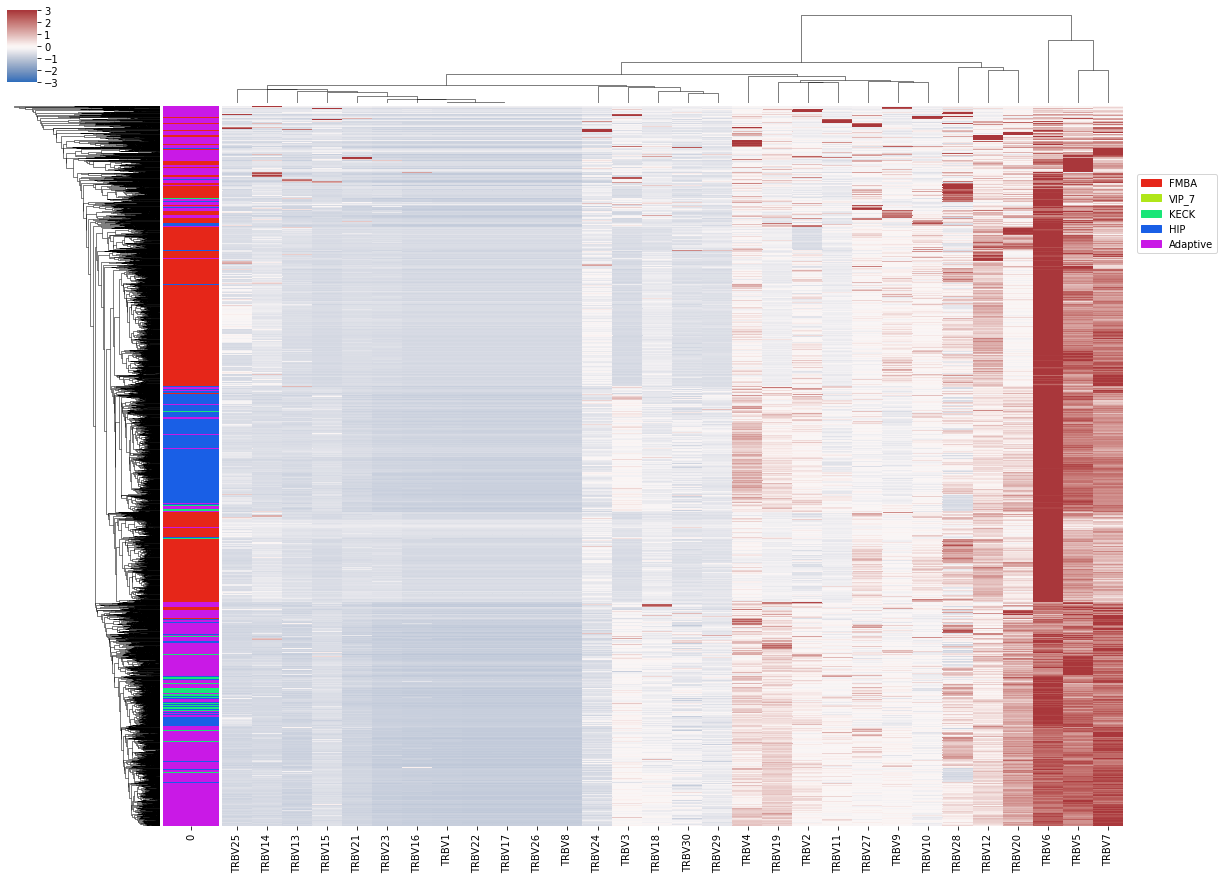

In [307]:
plot_V_usage_z_scored(v_usage_all)


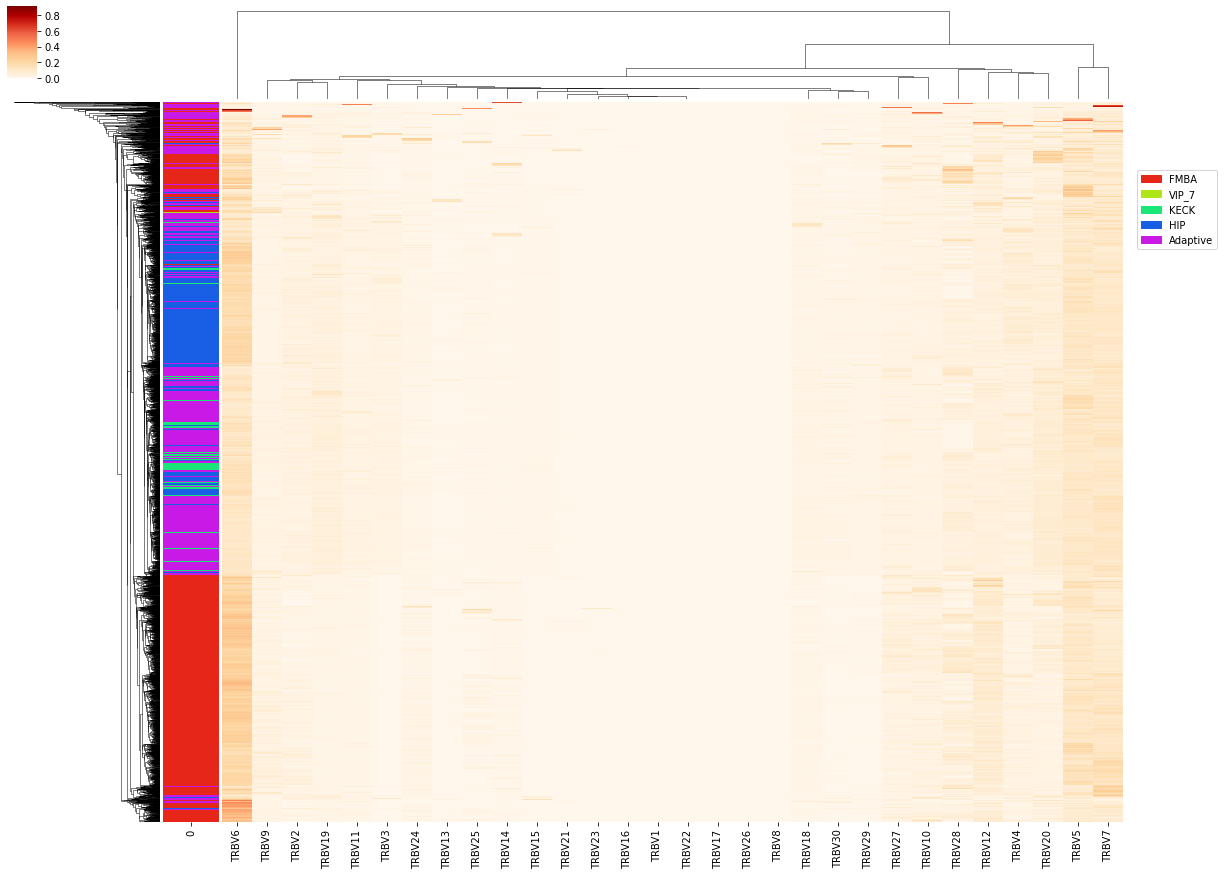

In [308]:
plot_V_usage_z_scored(v_usage_all, z_score=False)


In [309]:
v_usage_all["Batch"].value_counts()


FMBA        1245
Adaptive    1136
HIP          665
KECK         120
VIP_7          7
Name: Batch, dtype: int64

## Find scaling factors for each TRBV in each batch

In [310]:
v_usage_all.head()


sample_id    TRBV17     TRBV2  \
0  /home/taumata/COV_V_usage_adjustment_v2/Adapti...  0.000002  0.053993   
1  /home/taumata/COV_V_usage_adjustment_v2/Adapti...  0.000000  0.043651   
2  /home/taumata/COV_V_usage_adjustment_v2/Adapti...  0.000030  0.033258   
3  /home/taumata/COV_V_usage_adjustment_v2/Adapti...  0.000000  0.034344   
4  /home/taumata/COV_V_usage_adjustment_v2/Adapti...  0.000000  0.030081   

     TRBV27  TRBV26    TRBV13    TRBV19     TRBV1    TRBV28    TRBV30  ...  \
0  0.029756     0.0  0.007217  0.063226  0.000670  0.006220  0.034791  ...   
1  0.032528     0.0  0.075635  0.047296  0.000436  0.082183  0.013274  ...   
2  0.032073     0.0  0.004931  0.063073  0.000533  0.031523  0.025534  ...   
3  0.042057     0.0  0.006167  0.053487  0.000337  0.082442  0.029472  ...   
4  0.033681     0.0  0.006622  0.062362  0.000340  0.008204  0.039983  ...   

     TRBV23    TRBV21    TRBV10     TRBV6    TRBV22    TRBV29     TRBV4  \
0  0.003151  0.007230  0.029779  0.104002  0.000009  0.025499  0.048720   
1  0.001899  0.004856  0.025560  0.107865  0.000002  0.020245  0.034464   
2  0.001968  0.006346  0.037751  0.141287  0.000002  0.021007  0.064121   
3  0.002163  0.006017  0.028968  0.104255  0.000003  0.023638  0.052129   
4  0.001475  0.004452  0.028389  0.119420  0.000003  0.019436  0.054778   

     TRBV20    TRBV24     Batch  
0  0.100608  0.017269  Adaptive  
1  0.066853  0.008075  Adaptive  
2  0.060413  0.014884  Adaptive  
3  0.102940  0.012845  Adaptive  
4  0.079217  0.005346  Adaptive  

[5 rows x 32 columns]

In [317]:
scaling_factor = find_batch_scaling_factor(v_usage_all)


Median V-usage
            FMBA     VIP_7      KECK       HIP  Adaptive
TRBV6   0.231559  0.263514  0.143894  0.183328  0.115053
TRBV5   0.116073  0.115386  0.101975  0.122175  0.108919
TRBV7   0.109561  0.106472  0.104751  0.106263  0.122049
TRBV12  0.080905  0.078899  0.045408  0.046907  0.048458
TRBV20  0.039873  0.019288  0.085014  0.058332  0.076524
TRBV4   0.032964  0.045394  0.049319  0.067625  0.044408
TRBV28  0.054467  0.024646  0.050545  0.039533  0.041667
TRBV2   0.024296  0.049790  0.039475  0.041491  0.036910
TRBV19  0.018159  0.014442  0.044970  0.047876  0.053079
TRBV27  0.037693  0.035243  0.044570  0.027513  0.032211
TRBV9   0.037008  0.047973  0.034378  0.021959  0.032038
TRBV10  0.040515  0.035755  0.026735  0.030686  0.027705
TRBV11  0.017303  0.014741  0.032439  0.025563  0.032602
TRBV3   0.000627  0.000413  0.039421  0.031912  0.030177
TRBV18  0.014527  0.015530  0.022791  0.019297  0.025278
TRBV24  0.019304  0.025182  0.015995  0.016764  0.012090
TRBV30  0.005774

## Adjust frequencies

In [320]:
clonoset=pd.read_csv("/home/taumata/COV_V_usage_adjustment_v2/Adaptive_functional/INCOV057-AC-3_TCRB.tsv.txt",
                     sep="\t")


In [321]:
clonoset.head()


count      freq                                         cdr3nt  \
0   5953  0.008676        TGTGCCAGCATCCGGGCCGAGAACACTGAAGCTTTCTTT   
1   5953  0.008676        TGTGCCAGCATCCGGGCCGAGAACACTGAAGCTTTCTTT   
2   5953  0.008676        TGTGCCAGCATCCGGGCCGAGAACACTGAAGCTTTCTTT   
3   2420  0.003527  TGCAGTGCTACTACGACAGAAACCTCCTACAATGAGCAGTTCTTC   
4   2323  0.003385  TGTGCCAGCAGCCGACTAGCGGGGGAGCAAGAGACCCAGTACTTC   

            cdr3aa         v         d        j  VEnd  DStart  DEnd  JStart  
0    CASIRAENTEAFF   TRBV6-5  IGHD1-14  TRBJ1-1    10      10    15      20  
1    CASIRAENTEAFF   TRBV6-5  IGHD1-14  TRBJ1-1    10      10    15      20  
2    CASIRAENTEAFF   TRBV6-5  IGHD1-14  TRBJ1-1    10      10    15      20  
3  CSATTTETSYNEQFF  TRBV20-1  IGHD5-12  TRBJ2-1    10      10    16      23  
4  CASSRLAGEQETQYF   TRBV6-4     TRBD2  TRBJ2-5    11      13    23      27

In [327]:
adjust_frequencies_batch("/home/taumata/COV_V_usage_adjustment_v2/Adaptive_functional/INCOV057-AC-3_TCRB.tsv.txt",
                        "..", scaling_factor["Adaptive"]).head(10)


count      freq                                             cdr3nt  \
0    5953  0.012954            TGTGCCAGCATCCGGGCCGAGAACACTGAAGCTTTCTTT   
2    5953  0.012954            TGTGCCAGCATCCGGGCCGAGAACACTGAAGCTTTCTTT   
1    5953  0.012954            TGTGCCAGCATCCGGGCCGAGAACACTGAAGCTTTCTTT   
4    2323  0.005055      TGTGCCAGCAGCCGACTAGCGGGGGAGCAAGAGACCCAGTACTTC   
11   1360  0.002960      TGTGCCAGCAGTGTGAGCGAACCCTCTGGAAACACCATATATTTT   
3    2420  0.002519      TGCAGTGCTACTACGACAGAAACCTCCTACAATGAGCAGTTCTTC   
5    2307  0.002402         TGCAGTGCCCGGATCGGCGGGGGCCAAGAGACCCAGTACTTC   
15   1075  0.002339  TGTGCCAGCAGTTACCCCGAGGGGGGATCCTATTTCCTGGGCTACA...   
8    1630  0.002226         TGTGCCAGCAGTACACTACAGGGGTCCTCACCCCTCCACTTT   
9    1630  0.002226         TGTGCCAGCAGTACACTACAGGGGTCCTCACCCCTCCACTTT   

               cdr3aa       v         d        j  VEnd  DStart  DEnd  JStart  
0       CASIRAENTEAFF   TRBV6  IGHD1-14  TRBJ1-1    10      10    15      20  
2       CASIRAENTEAFF   TRBV6  IGHD1-14  TRBJ1-1    10      10    15      20  
1       CASIRAENTEAFF   TRBV6  IGHD1-14  TRBJ1-1    10      10    15      20  
4     CASSRLAGEQETQYF   TRBV6     TRBD2  TRBJ2-5    11      13    23      27  
11    CASSVSEPSGNTIYF   TRBV6  IGHD3-10  TRBJ1-3    13      17    23      23  
3     CSATTTETSYNEQFF  TRBV20  IGHD5-12  TRBJ2-1    10      10    16      23  
5      CSARIGGGQETQYF  TRBV20  IGHD1-14  TRBJ2-5     8       8    13      23  
15  CASSYPEGGSYFLGYTF   TRBV6  IGHD7-27  TRBJ1-2    15      22    30      39  
8      CASSTLQGSSPLHF  TRBV28  IGHD4-11  TRBJ1-6    12      13    20      27  
9      CASSTLQGSSPLHF  TRBV28  IGHD4-11  TRBJ1-6    12      13    20      27

In [326]:
#--!!Clonotype counts becomes senseless after normalization!!--

def adjust_frequencies_batch(input_file_path, out_file_path, size_factor,
                             colapse_V_subfamilies=True,
                             make_freq_sum_to_one=True):
    #--Read clonoset
    clonoset=pd.read_csv(input_file_path,
                    sep="\t")
    #--sometimes more than one V-segment is assigned to clonotype (HIP_full for example)
    #so let's take only the first one V-segment
    clonoset["v"]=clonoset["v"].apply(lambda x: x.split(",")[0])    
    #--Colapse V subfamilies
    if colapse_V_subfamilies:
        clonoset["v"]=[xT.split("-")[0] for xT in clonoset["v"]]
    #--Multiply clonotypes frequencies by scaling factor    
    for trbv in size_factor:
        if size_factor[trbv]==0: #remove such V-segments
            clonoset=clonoset.loc[clonoset["v"]!=trbv,:]
        else:
            clonoset.loc[clonoset["v"]==trbv,"freq"]=clonoset.loc[clonoset["v"]==trbv,"freq"]*size_factor[trbv]
    #--Make frequency in samples sum to one (if wish)
    if make_freq_sum_to_one:
        clonoset["freq"]=clonoset["freq"]/sum(clonoset["freq"])
    #--Sort clonotypes by frequency 
    clonoset=clonoset.sort_values(by="freq", axis=0, ascending=False)
    return clonoset
    clonoset.to_csv(out_file_path, sep="\t", index=False)
    return (input_file_path,"good")

trbv_frequency_df.loc[trbv_frequency_df.sum(axis=1).sort_values(ascending=False).index]


FMBA     VIP_7      KECK       HIP  Adaptive
TRBV6   0.201598  0.263514  0.133127  0.205575  0.116345
TRBV7   0.106681  0.103481  0.102530  0.102725  0.133330
TRBV5   0.097891  0.115386  0.102805  0.121794  0.103425
TRBV12  0.123130  0.076745  0.042558  0.046864  0.049030
TRBV20  0.061770  0.019288  0.078558  0.041001  0.080076
TRBV28  0.054467  0.036862  0.063992  0.033269  0.070254
TRBV4   0.024314  0.038629  0.046817  0.058303  0.048720
TRBV27  0.050386  0.035243  0.044205  0.029223  0.034867
TRBV10  0.081185  0.027285  0.026780  0.028651  0.029768
TRBV19  0.018542  0.014442  0.051222  0.041703  0.060819
TRBV2   0.004078  0.049790  0.035317  0.039896  0.042066
TRBV9   0.032983  0.037098  0.039670  0.020968  0.032189
TRBV11  0.012528  0.015790  0.029637  0.026695  0.034155
TRBV3   0.002094  0.000499  0.034456  0.034832  0.032286
TRBV30  0.010458  0.003989  0.028539  0.026230  0.034791
TRBV24  0.016812  0.034868  0.013603  0.013557  0.017269
TRBV18  0.008324  0.015530  0.020885  0.015370  0.028539
TRBV29  0.007639  0.002722  0.023219  0.016789  0.022481
TRBV25  0.000962  0.032891  0.008450  0.010695  0.008346
TRBV14  0.007132  0.021443  0.008179  0.011247  0.009974
TRBV15  0.000164  0.000197  0.013116  0.009033  0.013397
TRBV13  0.003321  0.002166  0.007795  0.007799  0.005639
TRBV21  0.002237  0.003536  0.004076  0.003322  0.006938
TRBV23  0.005797  0.003214  0.001724  0.001441  0.002501
TRBV16  0.000000  0.000000  0.000853  0.000590  0.000781
TRBV1   0.000000  0.000000  0.000486  0.000449  0.000507
TRBV22  0.000000  0.000000  0.000007  0.000000  0.000006
TRBV26  0.000000  0.000000  0.000008  0.000000  0.000000
TRBV8   0.000000  0.000000  0.000007  0.000000  0.000000
TRBV17  0.000000  0.000000  0.000000  0.000000  0.000001

In [ ]:
minimum_number_of_TCRs=2000

adaptive_stats=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/AB_corr_functional/ncfilter.summary.txt",
                           sep="\t",header=0)

normal_size_sammples=list(adaptive_stats.loc[adaptive_stats["passed_clones"]>minimum_number_of_TCRs,"sample_id"])

input_folder="/home/taumata/COV_AdaptiveBiotech_v2/AB_corr_functional"

output_folder="/home/taumata/COV_AdaptiveBiotech_v2/AB_func_batch_adjusted_frequencies_withReseq_v2"

#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def adjust_frequencies_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            size_factor=size_factor["AB"]):
    result=adjust_frequencies_batch(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             size_factor)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(adjust_frequencies_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        
        
        
        

In [ ]:
    return (path_to_input_file,"good")

def filter_unfunctional_clones_and_small_samples_batch(list_with_sample_names, folder_with_files, output_folder, cores=10):
    #create output folder if it does not exist
    if not os.path.exists(output_folder): 
        os.mkdir(output_folder)
        
    input_files_paths=[str(folder_with_files)+"/"+str(sample_name) for sample_name in list_with_sample_names]
    output_files_paths=[str(output_folder)+"/"+str(sample_name) for sample_name in list_with_sample_names]
    
    pool = mp.Pool(cores) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
    results=pool.starmap(filter_unfunctional_clones_and_small_samples, zip(input_files_paths,output_files_paths))
    pool.close()
    good_or_bad=dict(results)
    return good_or_bad